In [1]:
import os
import glob
import json
import geojson
import zipfile
import rasterio
import pyproj
import pathlib
import pandas

import geopandas as gpd
import rasterio.features
from rasterio import features
from rasterio.plot import show
from rasterio.merge import merge   
from rasterio.plot import show
from shutil import copyfile
from pathlib import Path
from shapely.geometry import Polygon, box
from shapely import geometry, wkt
from pprint import pprint, pformat
import matplotlib.pyplot as plt

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
from terracatalogueclient import Catalogue 
from creodias_finder import query, download

**Inputs**

In [2]:

# Name of the AOI
name = "uk"

# AOI formatL: shp & geojson
format_aoi = "shp"

# Start and end date for S2 scenes
date_start, date_end= "20210501", "20211030"

# WorldCover - https://viewer.esa-worldcover.org/worldcover
name_wc, password_wc = "sulova", "Sulova327"

# Sentinel S2 - https://apihub.copernicus.eu/apihub
sentinel_user, sentinel_pw = "sulova327", "sulova327"

# Creodias Copernicus DEM(30m) - https://finder.creodias.eu/
creodias_user, creodias_pw = "ansu@dhigroup.com", "Sulova327"

# Directories for AOI, work directory, S2 tile Grid, polygons of specific crops
dir_AOI =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}/AOI")
dir_work =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}")
S2_Grid =  gpd.read_file('/ncr2420/ANSU/3_Data/S2-Tiles/sentinel2_tiles_world.shp')
dir_polygons =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}/MS_Bounds/Field Bounds")

# Value for reclassification
value_class = 73


# 1. Merge all the AOI files

/home/jovyan/.conda/envs/py3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/merge.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/merge.geojson does not support layer creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


Number of files: 8


[]

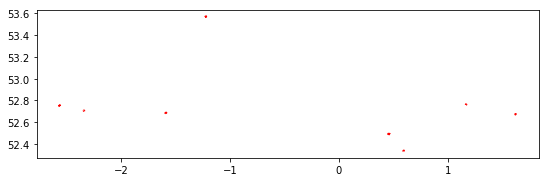

In [4]:
# delete previous files in the aoi folder
    
if os.path.isfile(os.path.join(dir_AOI, f'merge.geojson')):
    os.remove(os.path.join(dir_AOI, f'merge.geojson'))
if os.path.isfile(os.path.join(dir_AOI, f'merge.shp')):
    os.remove(os.path.join(dir_AOI, f'merge.shp'))    
   

files = glob.glob(f'{dir_AOI}/*.{format_aoi}')
print('Number of files:',len(files))
    
# merge AOI files together for finding S2 tiles
gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
gdf_merge.crs = "EPSG:4326"
merge_file = gdf_merge.to_file(os.path.join(dir_AOI, f'merge.geojson'), driver='GeoJSON')
merge_file = gdf_merge.to_file(os.path.join(dir_AOI, f'merge.shp'))

ax_AOI = gdf_merge.plot(figsize = (9,13),facecolor = "none", lw = 2, edgecolor = 'red')
ax_AOI.plot()

# 1.1 Find the matching S2 tiles

/home/jovyan/.conda/envs/py3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and EPSG:4326
  other.crs))


['30UWD', '30UXE', '30UYD', '31UCU', '31UDU']


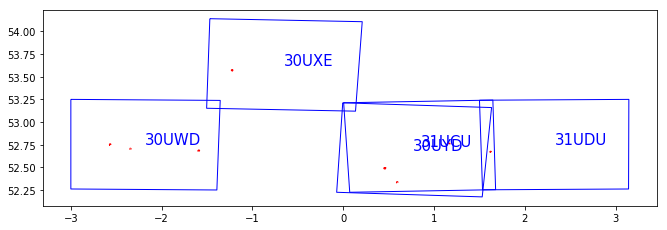

In [5]:
# intersection of S2 with AOI
intersection = gpd.overlay(S2_Grid, gdf_merge, how='intersection')
tiles_name = intersection['Name'].unique().tolist()
print(tiles_name)

# Plot of the S2 tiles and AOI
S2_Tile_Selection = S2_Grid[S2_Grid['Name'].isin(tiles_name)]
S2_Tile_Plot = S2_Tile_Selection.plot(figsize = (11,16), facecolor="none", 
                                      edgecolor = 'blue', lw = 1, legend = True,
                                      legend_kwds = {'bbox_to_anchor':(0, 1.05),'fontsize':10,})

ax = gdf_merge.plot(ax = S2_Tile_Plot, facecolor = "none", lw = 2, edgecolor = 'red',legend = True, legend_kwds = {'bbox_to_anchor':(2, 1.05),'fontsize':15,})

for i, geo in S2_Tile_Selection.centroid.iteritems():
    ax.annotate(s=S2_Tile_Selection.Name[i], xy = [geo.x, geo.y], color="blue",fontsize = 15,)

# 1.2 Select S2 tiles 

In [6]:
#tiles_name = ['31UDU',"30UXE"]
tiles_name = ["30UWD","31UCU"]

CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/30UWD.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/30UWD.geojson does not support layer creation option ENCODING
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/31UCU.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/31UCU.geojson does not support layer creation option ENCODING
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/uk.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/uk.geojson does not support layer creation option ENCODING


Saving the uk tile:/ncr2420/ANSU/6_Tasks/2110_ET/uk/30UWD.geojson  
Saving the uk tile:/ncr2420/ANSU/6_Tasks/2110_ET/uk/31UCU.geojson  
Number of files: 2


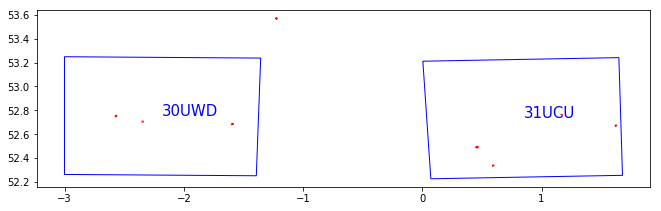

In [7]:
# delete previsou files in the folder
file_json = glob.glob(f'{dir_work}/*.geojson')
for f in file_json:
    if os.path.isfile(f):
        os.remove(f)

# selec S2 tiles within the AOI        
S2_Tile_Selection = S2_Grid[S2_Grid['Name'].isin(tiles_name)]

# Plot of the S2 tiles and AOI
S2_Tile_Plot = S2_Tile_Selection.plot(figsize = (11,16), facecolor="none", 
                                      edgecolor = 'blue', lw = 1, legend = True,
                                      legend_kwds = {'bbox_to_anchor':(0, 1.05),'fontsize':10,})
ax = gdf_merge.plot(ax = S2_Tile_Plot, facecolor = "none", lw = 2, edgecolor = 'red',legend = True, legend_kwds = {'bbox_to_anchor':(2, 1.05),'fontsize':15,})
for i, geo in S2_Tile_Selection.centroid.iteritems():
    ax.annotate(s=S2_Tile_Selection.Name[i], xy = [geo.x, geo.y], color="blue",fontsize = 15,)
    
# Save S2 tile as a geojson file
for index, row in S2_Tile_Selection.iterrows():
    name_s2 = row["Name"]
    polygon = S2_Tile_Selection.loc[S2_Tile_Selection['Name'] == name_s2]
    out_name = os.path.join(dir_work, "{0}.geojson".format(name_s2))
    print("Saving the {0} tile:{1}  ".format(name,out_name))
    polygon.to_file(out_name, driver='GeoJSON')
        
        
# find the all AOI to one shp
files = glob.glob(f'{dir_work}/*.geojson')
print('Number of files:',len(files))
out_merge = os.path.join(dir_work, f"{name}.geojson")
gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
gdf_merge.crs = "EPSG:4326"
merge_file = gdf_merge.to_file(out_merge, driver='GeoJSON')



# 1.3 S2 scenes


In [8]:

#api_url='https://apihub.copernicus.eu/dhus'
api_url='https://scihub.copernicus.eu/dhus'

area = geojson_to_wkt(read_geojson(out_merge))

print(area)
output_file = os.path.join(dir_work, f"{name}_scenes.txt")

query_kwargs = {
    "platformname": "Sentinel-2",
    "producttype": "S2MSI1C",
    "cloudcoverpercentage": (0, 90),
    "date": (date_start, date_end),
    "tileid": area}

product = dict()
scenes = []

for tile in tiles_name:
    kw = query_kwargs.copy()
    kw["tileid"] = tile
    api = SentinelAPI(sentinel_user, sentinel_pw,api_url)
    api_product = api.query(**kw)
    dates = []
   
    for key, value in api_product.items():
        dates.append(value['datatakesensingstart'])
    dates = sorted(dates)[::-1]
    
    for d in dates:
        scenes.append({"date":f'{d:%Y-%m-%d}', 'tile':f'T{tile}'})

print(json.dumps(scenes))
with open(output_file, "w") as fp:
    fp.write(json.dumps(scenes, indent=1))

POLYGON((-3.0003 53.2496,-1.3551 53.2383,-1.3918 52.2516,-3.0003 52.2625,-3.0003 53.2496))
[{"date": "2021-10-24", "tile": "T30UWD"}, {"date": "2021-10-21", "tile": "T30UWD"}, {"date": "2021-10-16", "tile": "T30UWD"}, {"date": "2021-10-13", "tile": "T30UWD"}, {"date": "2021-10-11", "tile": "T30UWD"}, {"date": "2021-10-06", "tile": "T30UWD"}, {"date": "2021-10-03", "tile": "T30UWD"}, {"date": "2021-10-01", "tile": "T30UWD"}, {"date": "2021-09-29", "tile": "T30UWD"}, {"date": "2021-09-28", "tile": "T30UWD"}, {"date": "2021-09-26", "tile": "T30UWD"}, {"date": "2021-09-24", "tile": "T30UWD"}, {"date": "2021-09-18", "tile": "T30UWD"}, {"date": "2021-09-16", "tile": "T30UWD"}, {"date": "2021-09-13", "tile": "T30UWD"}, {"date": "2021-09-09", "tile": "T30UWD"}, {"date": "2021-09-08", "tile": "T30UWD"}, {"date": "2021-09-06", "tile": "T30UWD"}, {"date": "2021-09-04", "tile": "T30UWD"}, {"date": "2021-08-29", "tile": "T30UWD"}, {"date": "2021-08-25", "tile": "T30UWD"}, {"date": "2021-08-22", "ti

# 2. Copernicus DEM

In [9]:
#create folder with the AOI name
dem_dir = os.path.join(dir_work,"DEM")

if not os.path.exists(dem_dir):
    os.makedirs(dem_dir)   

dem_aoi = f"{dir_work}/{name}.geojson"

merge_gpd = gpd.read_file(dem_aoi)
bounds_AOI = merge_gpd.total_bounds
geometry = box(*bounds_AOI) 

results_update = []

results = query.query('CopDem', geometry =geometry)
for result in results.values():
    productType = result["properties"]["productType"]
    if productType == "SAR_DGE_30_PUBLIC":
        title = result["properties"]["title"]
        ids = result["id"]
        download_title= os.path.join(dem_dir,title)
        download_id = os.path.join(dem_dir,f"{ids}.zip")
        if not os.path.exists(download_id):
            results_update.append(ids)  

print("Number of downloads:", len(results_update))

paths = download.download_list(list(results_update), creodias_user, creodias_pw, dem_dir,threads=10, show_progress=False)

DEM_tif = glob.glob(os.path.join(dem_dir,f"*.zip"))

for path in DEM_tif:
    with zipfile.ZipFile(path, "r") as z:
        z.extractall(dem_dir)
    os.remove(path)
    

Number of downloads: 12


In [10]:
# Merge selected tiles
DEM_tif = glob.glob(os.path.join(f"{dem_dir}/DEM1*/Copernicus*/DEM/","*.tif"))

src_files_to_mosaic = []

for fp in DEM_tif:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
print("Number of downloads:", len(src_files_to_mosaic))  

mosaic, out_trans = merge(src_files_to_mosaic)    

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
    "height": mosaic.shape[1],"width": mosaic.shape[2],"transform": out_trans} )
with rasterio.open(f"{dir_work}/DEM.tif", "w", **out_meta) as dest:
    dest.write(mosaic)

Number of downloads: 12


# 3. Land Cover - World Cover

In [11]:
# for tiles 

tileList = []

for tile in tiles_name:
    merge_gpd = gpd.read_file(f"{dir_work}/{tile}.geojson")
    bounds_AOI = merge_gpd.total_bounds
    geometry = box(*bounds_AOI)      
    # create catalogue object and authenticate 
    catalogue = Catalogue().authenticate() 
    catalogue = catalogue.authenticate_non_interactive(name_wc, password_wc) 
    # search for products in the WorldCover collection 
    products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry) 
    for c in products:        
        title = c.properties['title']
        file_dir = f"{dir_work}/WorldCover/{title}"
        if not os.path.isdir(file_dir):
            print(f"{tile} - {title} file NOT exists")
            products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry)
            catalogue.download_products(products, os.path.join(dir_work, f"WorldCover"), force=True)
        else:
            print(f"{tile} - {title} exists")
            
            
LC_tif = glob.glob(os.path.join(f"{dir_work}/WorldCover/*/","*Map.tif"))
src_files_to_mosaic = []

for fp in LC_tif:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)   

mosaic, out_trans = merge(src_files_to_mosaic)

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans} )
out_WorldCover  = f"{dir_work}/WorldCover.tif"
with rasterio.open(out_WorldCover, "w", **out_meta) as dest:
    dest.write(mosaic)
         

30UWD - ESA_WorldCover_10m_2020_v100_N51W003 file NOT exists
30UWD - ESA_WorldCover_10m_2020_v100_N51W006 exists
31UCU - ESA_WorldCover_10m_2020_v100_N51E000 file NOT exists


# 4. Reclassify Land Cover - World Cover

CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/MS_Bounds/Field Bounds/merge_polygons.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/MS_Bounds/Field Bounds/merge_polygons.geojson does not support layer creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


Number of files: 8


[]

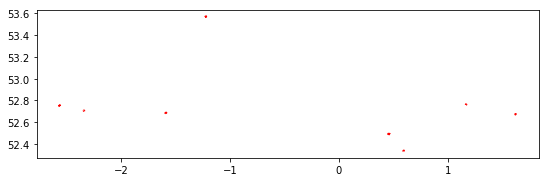

In [12]:
# get all polygons together and merge them for classification

if os.path.isfile(os.path.join(dir_polygons, f'merge_polygons.geojson')):
    os.remove(os.path.join(dir_polygons, f'merge_polygons.geojson'))
if os.path.isfile(os.path.join(dir_polygons, f'merge_polygons.shp')):
    os.remove(os.path.join(dir_polygons, f'merge_polygons.shp'))   
    
files = glob.glob(f'{dir_polygons}/*.{format_aoi}')
print('Number of files:',len(files))

# merge AOI files together for finding S2 tiles
gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
gdf_merge.crs = "EPSG:4326"
merge_file = gdf_merge.to_file(os.path.join(dir_polygons, f'merge_polygons.geojson'), driver='GeoJSON')
merge_file = gdf_merge.to_file(os.path.join(dir_polygons, f'merge_polygons.shp'))

ax_AOI = gdf_merge.plot(figsize = (9,13),facecolor = "none", lw = 2, edgecolor = 'red')
ax_AOI.plot()

In [13]:
def rasterize_vector(gdf, profile, **kwargs):
    gdf = gdf.to_crs(profile['crs'])
    geoms = [g.__geo_interface__ for g in gdf.geometry.values]
    mask = rasterio.features.rasterize(
            geoms,
            out_shape=(profile['width'],profile['height']),
            transform=profile['transform'], fill= 0,
            **kwargs)
    return mask

def mask_raster_with_vector(rasterfile, vectorfile, path ):
    with rasterio.open(rasterfile) as src_ras:
        data_down = src_ras.read(1)
        profile = src_ras.profile.copy()
            
    gdf = gpd.read_file(vectorfile)
   
    mask = rasterize_vector(gdf, profile)
    out_file = str(path + "rasterize.tif")
    with rasterio.open(out_file, "w", **profile) as dst:
        dst.write(mask.astype(rasterio.uint8), 1)
    
    # Create classification
    with rasterio.open(out_file) as src_top:
        data_top = src_top.read(1)
        height, width = data_top.shape  
        profile = src_top.profile
        data = np.where(data_top==1, value_class, data_down)
    
    out_name = os.path.join(path,f'WorldCover_{name}.tif')
      
    with rasterio.open(out_name,'w', **profile) as dst_final:
        print(data)
        dst_final.write(data.astype(rasterio.uint8), 1)
    
    return out_name


In [14]:
mask_raster_with_vector(out_WorldCover, merge_file, dir_work)

AttributeError: 'NoneType' object has no attribute 'startswith'

In [ ]:
def raster_file_singleband(path, rasterfile,data):
    with rasterio.open(rasterfile) as src:
        profile = src.profile.copy()
        print(profile)
    profile.update(driver="GTiff")
    with rasterio.open(str(path+"test_10.tif"), "w", **profile) as dst:
        dst.write(data.astype(rasterio.uint8), 1)
    return str(path+"test_10.tif")

In [ ]:
raster_file_singleband(out_fn,rst_fn,rasteer)

In [ ]:
raster_new= rasterio.open(out_fn+"test_10.tif")
show(raster_new)
raster_new.profile

In [ ]:
# open and update the metadata from the input raster for the output
rst = rasterio.open(rst_fn)
meta = rst.meta.copy()
meta.update(compress='lzw')

rst.read().shape



In [ ]:
# Open the file with GeoPANDAS read_file

polygons = gpd.read_file(shp_fn)
polygons.plot()
polygons.crs


In [ ]:
polygons_rasCRS = polygons.to_crs({'init': 'epsg:32631'})
polygons_rasCRS.crs
polygons_rasCRS.plot()

In [ ]:
#counties_pro= counties.set_crs(epsg=3857)
#counties_ proj = counties.to_crs('epsg:32631'

In [ ]:
polygons_rasCRS

In [ ]:
polygons_rasCRS["values_pix"] = polygons_rasCRS.value.astype(int)
polygons_rasCRS

In [ ]:
polygons_rasCRS['values_pix'].head()

In [ ]:
with rasterio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(polygons_rasCRS.geometry, polygons_rasCRS.values_pix))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

# 5. Copy constant files

In [ ]:
file_ads = ".adsapirc"
file_cds = ".cdsapirc"
file_flux = "fluxes_config_template"
file_Sen2Cor = "Sen2Cor_2.9.0_L2A_GIPP_template"

copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_ads}',os.path.join(dir_work, f"{file_ads}"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_cds}"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_flux}.txt"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_Sen2Cor}.xml"))

In [ ]:
X.S2GLC